# Logistic Regression - Titanic

We will be working with the [Titanic Data Set from Kaggle](https://www.kaggle.com/c/titanic).

We'll be trying to predict a classification: survival or deceased. ( Logistic Regression in Python for classification. )

We'll use a "semi-cleaned" version of the titanic data set, if you use the data set hosted directly on Kaggle, you may need to do some additional cleaning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## The Data

Let's start by reading in the titanic_train.csv file into a pandas dataframe.

In [2]:
train = pd.read_csv('titanic_train.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploratory Data Analysis

Let's begin some exploratory data analysis! We'll start by checking out missing data!

## Missing Data

We can use seaborn to create a simple heatmap to see where we are missing data!

<AxesSubplot:>

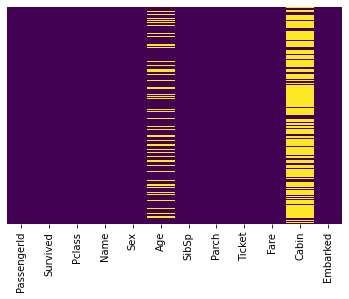

In [8]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis') # yellow missingS

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0"

<AxesSubplot:xlabel='Survived', ylabel='count'>

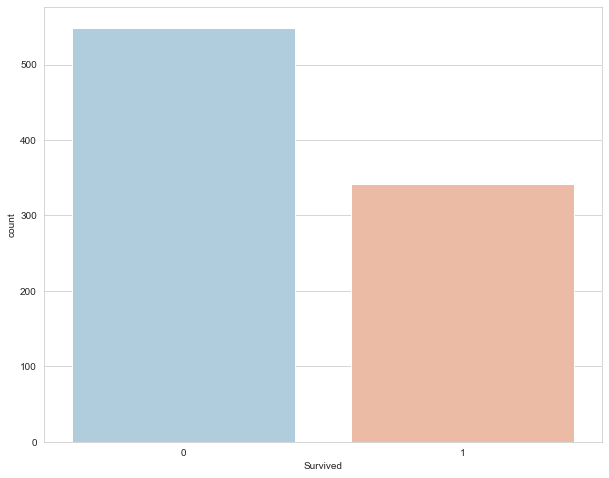

In [21]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 8))
sns.countplot(x='Survived',data=train,palette='RdBu_r')

[Text(0, 0, '549 (62%)'), Text(0, 0, '342 (38%)')]

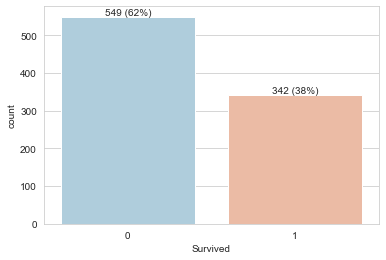

In [29]:
ax = sns.countplot(x='Survived',data=train,palette='RdBu_r')
        
abs_values = train['Survived'].value_counts(ascending=False)
rel_values = train['Survived'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

<AxesSubplot:xlabel='Survived', ylabel='count'>

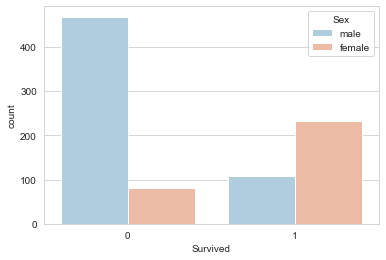

In [30]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')

<AxesSubplot:xlabel='Survived', ylabel='count'>

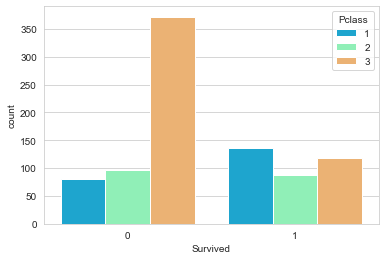

In [31]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

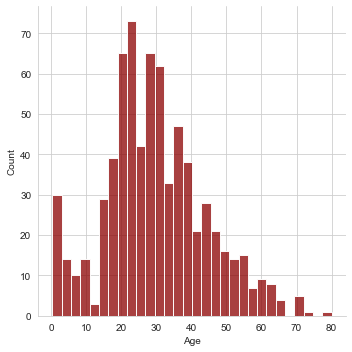

In [33]:
sns.displot(train['Age'].dropna(),kde=False,color='darkred',bins=30)

<AxesSubplot:>

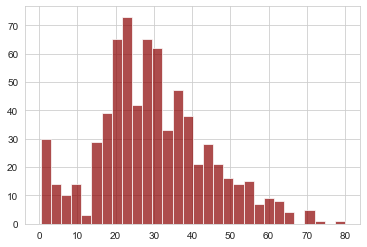

In [34]:
train['Age'].hist(bins=30,color='darkred',alpha=0.7)

In [35]:
train["Age"].mean()

29.69911764705882

[Text(0, 0, '608 (68%)'),
 Text(0, 0, '209 (23%)'),
 Text(0, 0, '28 (3%)'),
 Text(0, 0, '18 (2%)'),
 Text(0, 0, '16 (2%)'),
 Text(0, 0, '7 (1%)'),
 Text(0, 0, '5 (1%)')]

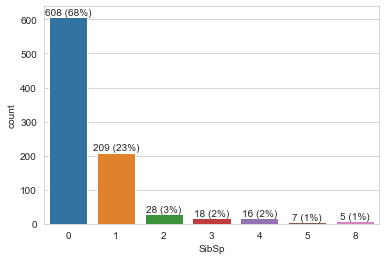

In [40]:
ax = sns.countplot(x='SibSp',data=train) # siblings count
        
abs_values = train['SibSp'].value_counts(ascending=False)
rel_values = train['SibSp'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

<AxesSubplot:>

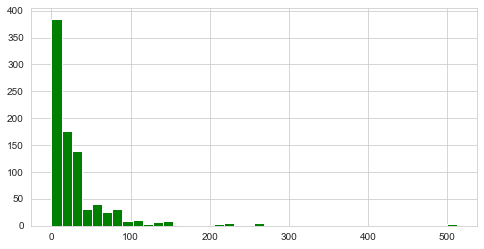

In [38]:
train['Fare'].hist(color='green',bins=40,figsize=(8,4))

____
### Cufflinks for plots
___


In [42]:
import cufflinks as cf
cf.go_offline()

In [43]:
train['Fare'].iplot(kind='hist',bins=30,color='green')

In [62]:
train["Age"].iplot(kind="histogram", bins=30, theme="white", title="Passenger's Ages",xTitle='Ages', yTitle='Count')

In [ ]:
train["male_age"]=train[train["Sex"]=="male"]["Age"]
train["female_age"]=train[train["Sex"]=="female"]["Age"]

train[["male_age","female_age"]].iplot(kind="histogram", bins=30, theme="white", title="Passenger's Ages",
         xTitle='Ages', yTitle='Count')

In [66]:
train.corr().iplot(kind='heatmap',colorscale="Blues", title="Feature Correlation Matrix")

In [70]:
train.iplot(kind="scatter", theme="white",x="Age",y="Fare", xTitle='Ages', yTitle='Fare', categories="Sex")

In [71]:
#converting Survived column to float64 to be able to use in plotly
train[['Survived']] = train[['Survived']].astype('float64', copy=False)

train.iplot(kind='bubble', x="Fare",y="Age",categories="Survived", size='Pclass', text='Name', xTitle='Fare', yTitle='Age')

In [73]:
survived_sex = train[train['Survived']==1]['Sex'].value_counts()
survived_sex

female    233
male      109
Name: Sex, dtype: int64

In [74]:
dead_sex = train[train['Survived']==0]['Sex'].value_counts()
dead_sex

male      468
female     81
Name: Sex, dtype: int64

In [75]:
df1 = pd.DataFrame([survived_sex,dead_sex])
df1.index = ['Survived','Dead']
df1.head()

,female,male
Survived,233,109
Dead,81,468


In [76]:
df1.iplot(kind='bar',barmode='stack', title='Survival by the Sex')

___
## Data Cleaning
We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation).
However we can be smarter about this and check the average age by passenger class.


<AxesSubplot:xlabel='Pclass', ylabel='Age'>

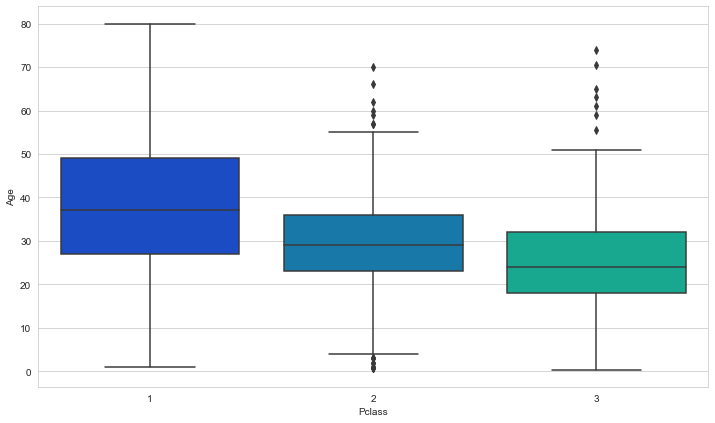

In [52]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

In [85]:
train.groupby('Pclass', as_index=False)['Age'].median()

,Pclass,Age
0,1,37.0
1,2,29.0
2,3,24.0


In [58]:
# pivot - Return reshaped DataFrame organized by given index / column values.
train[['Pclass', 'Age']].pivot(columns='Pclass', values='Age').iplot(kind='box')

We can see the wealthier passengers in the higher classes tend to be older, which makes sense.

In [86]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

Now apply that function!

In [87]:
# axis=0 is said to be "column-wise" and axis=1 "row-wise"
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)

Now let's check that heat map again!

<AxesSubplot:>

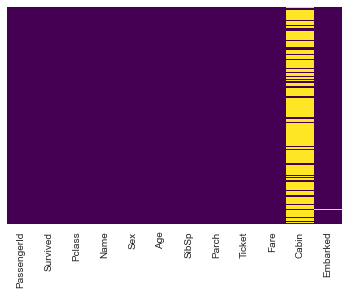

In [88]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Great! Let's go ahead and drop the Cabin column and the row in Embarked that is NaN.

In [89]:
train.drop('Cabin',axis=1,inplace=True)

In [90]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [92]:
train.dropna(inplace=True)

## Converting Categorical Features 

We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [94]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    float64
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(3), int64(4), object(4)
memory usage: 83.3+ KB


In [95]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [96]:
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [97]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1,0.0,3,22.0,1,0,7.2500
1,2,1.0,1,38.0,1,0,71.2833
2,3,1.0,3,26.0,0,0,7.9250
3,4,1.0,1,35.0,1,0,53.1000
4,5,0.0,3,35.0,0,0,8.0500


In [98]:
train = pd.concat([train,sex,embark],axis=1)

In [101]:
train.drop('PassengerId', axis=1, inplace=True)

In [103]:
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0.0,3,22.0,1,0,7.2500,1,0,1
1,1.0,1,38.0,1,0,71.2833,0,0,0
2,1.0,3,26.0,0,0,7.9250,0,0,1
3,1.0,1,35.0,1,0,53.1000,0,0,1
4,0.0,3,35.0,0,0,8.0500,1,0,1


# Building a Logistic Regression model

Let's start by splitting our data into a training set and test set.

## Train Test Split

In [108]:
from sklearn.model_selection import train_test_split

In [109]:
X = train.drop('Survived',axis=1)
y = train['Survived']

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.30, 
                                                    random_state=101)

## Training and Predicting

In [113]:
from sklearn.linear_model import LogisticRegression

In [117]:
logmodel = LogisticRegression(solver='lbfgs', max_iter=1000)

In [118]:
logmodel.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [119]:
predictions = logmodel.predict(X_test)

## Evaluation

We can check precision,recall,f1-score using classification report!

In [122]:
from sklearn.metrics import classification_report, confusion_matrix

In [123]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.82      0.92      0.87       163
         1.0       0.85      0.69      0.76       104

    accuracy                           0.83       267
   macro avg       0.84      0.81      0.82       267
weighted avg       0.83      0.83      0.83       267



In [124]:
confusion_matrix(y_test, predictions)

array([[150,  13],
       [ 32,  72]], dtype=int64)